For DBSCAN, I chose to use a dataset of wine, where the wine is labeled red or white, and there are verious chemical measurements of each wine instance.  Below are my imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import plotly
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D


I mounted my drive to import my dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_matrix = pd.read_csv('/content/drive/My Drive/CSC373_DMP_Mayr_Jack/DMP_Cluster_Analysis/wine_data.csv')
data_matrix

Mounted at /content/drive


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


DBSCAN can have trouble on higher dimensional data, so I visually chose what I believed to be the more important elements, and dropped the others

In [3]:
data_matrix = data_matrix.dropna()
data_matrix = data_matrix.drop(columns = ['chlorides', 'free sulfur dioxide', 'density', 'pH','alcohol',	'quality', 'fixed acidity' ])

Normalizing the data can be helpful when using DBSCAN so that variables are weighted the same. Since we do not know all too much about wine, this is the best approach.

In [4]:
normalized_data_matrix=(data_matrix.drop(columns=['type'])-data_matrix.drop(columns=['type']).min())/(data_matrix.drop(columns=['type']).max()-data_matrix.drop(columns=['type']).min())

In [5]:
#data_matrix = pd.DataFrame(data_matrix)
normalized_data_matrix

,volatile acidity,citric acid,residual sugar,total sulfur dioxide,sulphates
0,0.126667,0.216867,0.308282,0.377880,0.129213
1,0.146667,0.204819,0.015337,0.290323,0.151685
2,0.133333,0.240964,0.096626,0.209677,0.123596
3,0.100000,0.192771,0.121166,0.414747,0.101124
4,0.100000,0.192771,0.121166,0.414747,0.101124
...,...,...,...,...,...
6491,0.360000,0.048193,0.019939,0.073733,0.337079
6492,0.346667,0.048193,0.021472,0.087558,0.202247
6494,0.286667,0.078313,0.026074,0.078341,0.297753
6495,0.376667,0.072289,0.021472,0.087558,0.275281


To get an estimation of a good epsilon, we can look at a nearest neighbors measurement, and see where the curvature is the greatest

In [6]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(normalized_data_matrix)
distances, indices = nbrs.kneighbors(normalized_data_matrix)

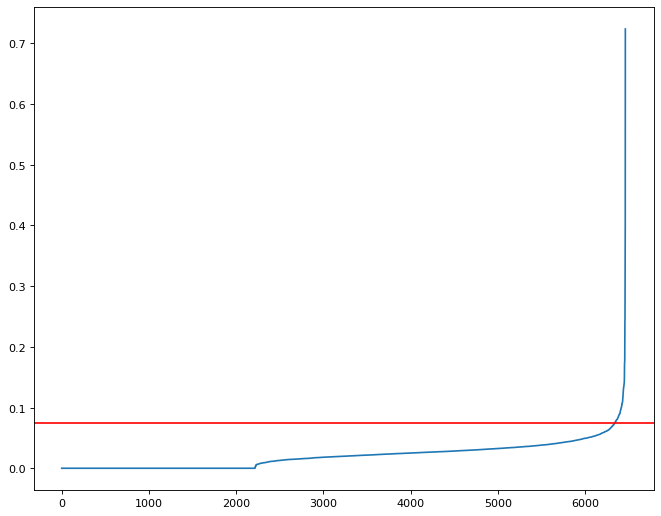

In [7]:
figure(figsize=(10, 8), dpi=80)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.axhline(y=0.075, color='r', linestyle='-')

In this case, it looks like an eps in the range of 0.07-0.08 is a good bet


Next, we will implement scikit-learn's DBSCAN function on our normalized matrix, and go ahead and label assigned clusters on 

In [8]:
clustering = DBSCAN(eps=0.080, min_samples=100).fit(normalized_data_matrix)
labels = clustering.labels_
print(len(labels))
normalized_data_matrix['type'] = data_matrix['type']
normalized_data_matrix['cluster'] = labels

normalized_data_matrix


6463


,volatile acidity,citric acid,residual sugar,total sulfur dioxide,sulphates,type,cluster
0,0.126667,0.216867,0.308282,0.377880,0.129213,white,0
1,0.146667,0.204819,0.015337,0.290323,0.151685,white,0
2,0.133333,0.240964,0.096626,0.209677,0.123596,white,0
3,0.100000,0.192771,0.121166,0.414747,0.101124,white,0
4,0.100000,0.192771,0.121166,0.414747,0.101124,white,0
...,...,...,...,...,...,...,...
6491,0.360000,0.048193,0.019939,0.073733,0.337079,red,1
6492,0.346667,0.048193,0.021472,0.087558,0.202247,red,1
6494,0.286667,0.078313,0.026074,0.078341,0.297753,red,1
6495,0.376667,0.072289,0.021472,0.087558,0.275281,red,1


To get an idea of the number of items in each cluster, we can run and modify the code below

In [9]:

white_wine = normalized_data_matrix[normalized_data_matrix['type'] == 'white']
cluster_0_white_wine  = white_wine[white_wine['cluster'] == 0]
red_wine = normalized_data_matrix[normalized_data_matrix['type'] == 'red']
cluster_1_red_wine  = red_wine[red_wine['cluster'] == 1]
print(len(white_wine))
print(len(cluster_0_white_wine))
print(len(red_wine))
print(len(cluster_1_red_wine))

4870
3917
1593
455


A 3D visualization of the data is below

In [10]:
fig = px.scatter_3d(normalized_data_matrix, x='volatile acidity', y='citric acid', z='total sulfur dioxide',
              color='cluster')
fig.show()
fig.write_html("/content/drive/My Drive/CSC373_DMP_Mayr_Jack/DMP_Cluster_Analysis/3dplot.html")

TSNE stands for t-distributed stochastic neighbor embedding, and it is a way of visualizing higher dimensional data.  This is another way of viewing higher dimensional data.  We can see our clustering makes sense by how the colors are separated out

In [11]:
X_embedded = TSNE(n_components=2).fit_transform(normalized_data_matrix.drop(columns = ['type', 'cluster']))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [12]:
normalized_data_matrix["x_component"]=X_embedded[:,0]
normalized_data_matrix["y_component"]=X_embedded[:,1]


In [13]:
fig = px.scatter(normalized_data_matrix, x="x_component", y="y_component", hover_name="type", color = "cluster", size_max=60)
fig.update_layout(
     height=800)
fig.show()
fig.write_html("/content/drive/My Drive/CSC373_DMP_Mayr_Jack/DMP_Cluster_Analysis/plot.html")